## Import necessary libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter

## Load prediction model

In [57]:
bgf = BetaGeoFitter()
bgf.load_model("../models/bgf_ltv_prediction_full_data.pkl")

bgf

<lifetimes.BetaGeoFitter: fitted with 1200 subjects, a: 0.00, alpha: 79.96, b: 0.14, r: 1.17>

## Load prepared data from CSV

In [58]:
df = pd.read_csv("../data/ltv_cleaned_data.csv", index_col=0)
summary_df = pd.read_csv("../data/ltv_prediction_data.csv", index_col=0)

df[["event_timestamp", "first_purchase_time", "cohort_week"]] = df[
    ["event_timestamp", "first_purchase_time", "cohort_week"]
].apply(pd.to_datetime)

summary_df[
    ["event_timestamp", "first_purchase_time", "cohort_week", "prediction_period"]
] = summary_df[
    ["event_timestamp", "first_purchase_time", "cohort_week", "prediction_period"]
].apply(
    pd.to_datetime
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              1200 non-null   object        
 1   event_timestamp      1200 non-null   datetime64[ns]
 2   first_purchase_time  1200 non-null   datetime64[ns]
 3   cohort_week          1200 non-null   datetime64[ns]
 4   product_id           1200 non-null   object        
 5   lifetime_months      1200 non-null   int64         
 6   price                1200 non-null   float64       
 7   frequency            1200 non-null   int64         
 8   revenue              1200 non-null   float64       
dtypes: datetime64[ns](3), float64(2), int64(2), object(2)
memory usage: 93.8+ KB


In [59]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 0 to 1199
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              1200 non-null   object        
 1   frequency            1200 non-null   float64       
 2   recency              1200 non-null   float64       
 3   T                    1200 non-null   float64       
 4   event_timestamp      1200 non-null   datetime64[ns]
 5   first_purchase_time  1200 non-null   datetime64[ns]
 6   cohort_week          1200 non-null   datetime64[ns]
 7   product_id           1200 non-null   object        
 8   revenue              1200 non-null   float64       
 9   prediction_period    1200 non-null   datetime64[ns]
 10  rest                 1200 non-null   float64       
 11  equity               1200 non-null   float64       
 12  ltv                  1200 non-null   float64       
 13  purchases            1200 non-null   f

In [80]:
prediction_months = 12
prediction_start_date = summary_df["event_timestamp"].max()
average_transaction_value = (
    summary_df["revenue"].sum() / summary_df["event_timestamp"].count()
)

average_transaction_value

47.128933333333336

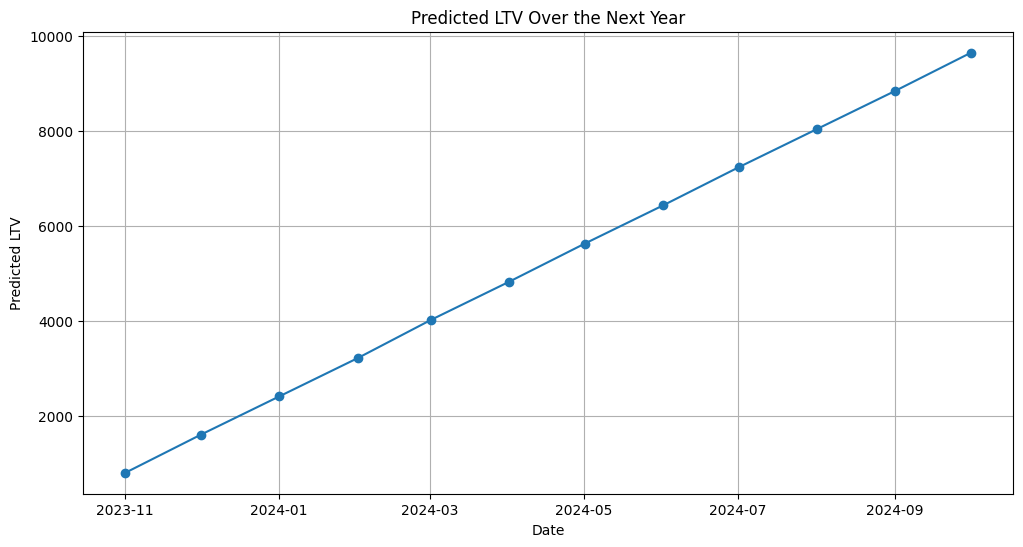

In [87]:
# We need to ensure predictions are aggregated properly:
monthly_ltv_predictions = []
for t in range(1, prediction_months + 1):
    monthly_predictions = bgf.conditional_expected_number_of_purchases_up_to_time(
        t, summary_df["frequency"], summary_df["recency"], summary_df["T"]
    )
    # Aggregate predictions for the month across all customers and multiply by average transaction value
    total_predicted_ltv = np.sum(monthly_predictions) * average_transaction_value
    monthly_ltv_predictions.append(total_predicted_ltv)

# Dates for plotting
prediction_dates = pd.date_range(
    start=prediction_start_date, periods=prediction_months, freq="MS"
)

# Create a DataFrame for plotting
predictions_df = pd.DataFrame(
    {"Date": prediction_dates, "Predicted LTV": monthly_ltv_predictions}
)

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(predictions_df["Date"], predictions_df["Predicted LTV"], marker="o")
plt.title("Predicted LTV Over the Next Year")
plt.xlabel("Date")
plt.ylabel("Predicted LTV")
plt.grid(True)
plt.show()

In [88]:
df.columns

Index(['user_id', 'event_timestamp', 'first_purchase_time', 'cohort_week',
       'product_id', 'lifetime_months', 'price', 'frequency', 'revenue'],
      dtype='object')

In [94]:
actual_revenue_by_cohort = (
    summary_df.groupby("cohort_week")["revenue"].sum().reset_index()
)

# Assuming 'bgf' is your fitted model
predicted_ltv_by_user = (
    bgf.conditional_expected_number_of_purchases_up_to_time(
        prediction_months,  # time in periods, e.g., months
        summary_df["frequency"],
        summary_df["recency"],
        summary_df["T"],
    )
    * average_transaction_value
)

# You then sum up these values for each cohort week
predicted_ltv_by_cohort = (
    summary_df.assign(predicted_ltv=predicted_ltv_by_user)
    .groupby("cohort_week")["predicted_ltv"]
    .sum()
    .reset_index()
)

comparison_df = actual_revenue_by_cohort.merge(
    predicted_ltv_by_cohort, on="cohort_week", how="left"
)

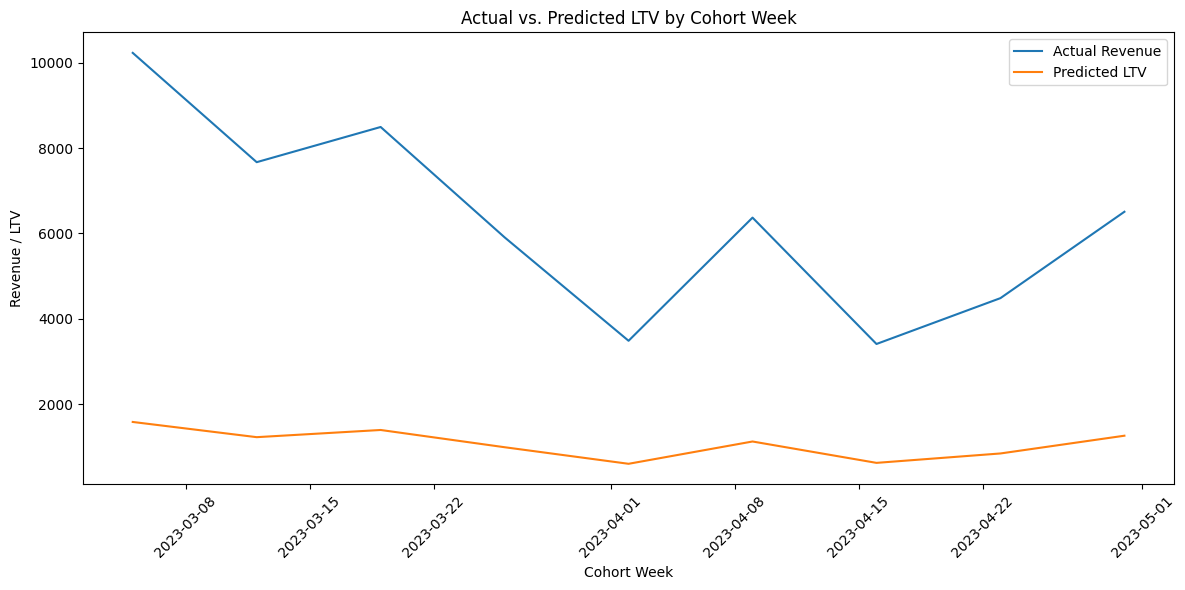

In [95]:
plt.figure(figsize=(12, 6))
plt.plot(comparison_df["cohort_week"], comparison_df["revenue"], label="Actual Revenue")
plt.plot(
    comparison_df["cohort_week"], comparison_df["predicted_ltv"], label="Predicted LTV"
)
plt.title("Actual vs. Predicted LTV by Cohort Week")
plt.xlabel("Cohort Week")
plt.ylabel("Revenue / LTV")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It's quite reasonable for predicted LTV values to be lower, especially if we expect churn or a drop-off in user engagement over time. We should keep in mind that high churn rates will lower the predicted LTV as the model expects that a certain percentage of customers will not continue to generate revenue.
Also it's often better for a model to be conservative in its estimates rather than overly optimistic. This helps businesses plan for a worst-case scenario and manage resources effectively.

Predicted LTV might not account for external factors that could increase customer lifespan or spending in the future, like improved product offerings, successful marketing strategies, or enhancements in customer service.

**To improve** the model we may consider:
1. Incorporate more features such as customer demographics, seasonality, marketing spend
2. Using different models. For example, combining several models or changing our main model. In this example we stopped on lifetimes Python library, which is works based on linear regrea

In [96]:
comparison_df

,cohort_week,revenue,predicted_ltv
0,2023-03-05,10229.31,1583.155752
1,2023-03-12,7668.86,1226.780217
2,2023-03-19,8493.20,1395.138898
3,2023-03-26,5907.77,991.170902
4,2023-04-02,3484.71,602.969967
5,2023-04-09,6369.90,1125.410082
6,2023-04-16,3409.77,624.722310
7,2023-04-23,4483.91,845.057696
8,2023-04-30,6507.29,1260.960654


In [97]:
comparison_df.to_csv("../data/ltv_comparison_data.csv")

In [98]:
predictions_df.to_csv("../data/ltv_predicted_data.csv")